# Mudstone Width Measurement

In [ ]:
import math
import json
import os
import imutils
from imutils import perspective, contours
import numpy as np
import cv2
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image

In [65]:
image_files = sorted(glob("data\\images/*.jpg"))
mask_files = sorted(glob("data\\masks/*.tiff"))

# 0 - scale, 1 - sandstone, 2 - mudstone
id2name = {0 : "scale", 1 : "sandstone", 2 : "mudstone"}
name2id = {"scale" : 0, "sandstone" : 1, "mudstone" : 2}
is_not_duplicate = lambda x: not x.endswith('(1).jpg') and not x.endswith('(1).tiff')
sort_by_number = lambda x: int(x.split("\\")[-1].split(".")[0])
image_files = list(filter(is_not_duplicate, image_files))
image_files = sorted(image_files, key=sort_by_number)
mask_files = list(filter(is_not_duplicate, mask_files))
mask_files = sorted(mask_files, key=sort_by_number)
len(image_files), len(mask_files)

(98, 98)

In [ ]:
def imshow(image_cv2):
    if image_cv2.ndim == 3:
        img = cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB)
    else:
        img = image_cv2.copy()
    img = Image.fromarray(img)
    return img

def get_img_and_mask(num):
    '''
    num should either be an index into image_files or a string of the form "num.jpg"
    '''
    if isinstance(num, str):
        ind = image_files.index(f"data\\images\\{num}.jpg")
        img = cv2.imread(image_files[ind])
        mask = cv2.imread(mask_files[ind], 0)
    else:
        img = cv2.imread(image_files[num])
        mask = cv2.imread(mask_files[num], 0)
    width = img.shape[1]
    img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_AREA)
    scale_factor = width / 256
    mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_AREA)

    return img, mask, scale_factor

def display(img, mask):
    _, axes = plt.subplots(1, 2, figsize=(4, 3))
    axes[0].imshow(imshow(img))
    axes[0].axis('off')
    axes[1].imshow(imshow(mask), cmap='gray')
    axes[1].axis('off')
    plt.tight_layout()
    plt.savefig('process_diagram/1.png', dpi=600)
    plt.show()  

In [66]:
store_dir = "data\\masks_viz"

for mask_file in mask_files:
    mask = cv2.imread(mask_file, 0)
    min_value, max_value = mask.min(), mask.max()
    norm_mask = (mask - min_value) / (max_value - min_value)
    norm_mask = (norm_mask * 255).astype("uint8")
    norm_mask = cv2.resize(norm_mask, (256, 256), interpolation=cv2.INTER_AREA)
    filename = mask_file.split("\\")[-1]
    filename = filename.replace(".tiff", ".jpg")
    cv2.imwrite(os.path.join(store_dir, filename), norm_mask)

In [ ]:
sample_img, sample_mask, factor = get_img_and_mask('9')
display(sample_img, sample_mask)

In [ ]:
# store_dir = "data\\masks_eroded_binary2"
# if not os.path.exists(store_dir):
#     os.mkdir(store_dir)
# for image_file, mask_file in zip(image_files, mask_files):
#     print(mask_file, image_file)
#     mask = cv2.imread(mask_file, 0)
#     img = cv2.imread(image_file)
#     mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_AREA)
#     img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_AREA)
#     background_mask = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY_INV)[1]
#     background_mask = cv2.morphologyEx(background_mask, cv2.MORPH_OPEN, np.ones((3, 9), np.uint8))
#     background_mask = cv2.morphologyEx(background_mask, cv2.MORPH_OPEN, np.ones((9, 3), np.uint8))
#     contours, _ = cv2.findContours(background_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     if len(contours) > 0:
#         largest_contour = max(contours, key=cv2.contourArea)
#         new_mask = np.zeros_like(background_mask)
#         cv2.drawContours(new_mask, [largest_contour], -1, 255, -1)
#         filename = mask_file.split("\\")[-1]
#         # replace tiff with jpg
#         filename = filename[:-4] + "jpg"
#         path = os.path.join(store_dir, filename)
#         # new_roi = cv2.bitwise_and(img, img, mask=new_mask)
#         cv2.imwrite(path, new_mask)

### Display Mask

In [ ]:
mask = sample_mask.copy()
thresh = np.where(mask == name2id["mudstone"], 255, 0).astype(np.uint8)
# Define a vertical kernel. The height of the kernel should be greater than the maximum height of the bridges you want to remove.
kernel = np.ones((32, 1), np.uint8)
morph_erode = cv2.erode(thresh, kernel, iterations=1)
morph_open = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)

fig, axes = plt.subplots(2, 2, figsize=(6, 4))
axes[0, 0].imshow(imshow(thresh))
axes[0, 0].axis('off')
axes[0, 1].imshow(imshow(morph_open))
axes[0, 1].axis('off')
axes[1, 0].imshow(imshow(cv2.bitwise_and(sample_img, sample_img, mask=thresh)))
axes[1, 0].axis('off')
axes[1, 1].imshow(imshow(cv2.bitwise_and(sample_img, sample_img, mask=morph_open)))
axes[1, 1].axis('off')
fig, axes = plt.subplots(1, 2, figsize=(4, 3))
axes[0].imshow(imshow(morph_open))
axes[0].axis('off')
axes[1].imshow(imshow(cv2.bitwise_and(sample_img, sample_img, mask=morph_open)))
axes[1].axis('off')
plt.tight_layout()
plt.subplots_adjust()
plt.savefig('process_diagram/2.png', dpi=600)

In [ ]:
def display_masks(N):
    # Generate N random numbers between 0 and 102 without replacement
    random_indices = np.random.choice(range(102), size=N, replace=False)

    fig, axes = plt.subplots(N, 4, figsize=(6, 15))

    for i, index in enumerate(random_indices):
        # Load image and mask and threshold
        sample_img, sample_mask, _ = get_img_and_mask(index)
        thresh = np.where(sample_mask == name2id["mudstone"], 255, 0).astype(np.uint8)
        # Define a vertical kernel.
        kernel = np.ones((32, 3), np.uint8)
        morph_open = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
        # Display the images
        axes[i, 0].imshow(imshow(thresh))
        axes[i, 0].axis('off')
        axes[i, 1].imshow(imshow(cv2.bitwise_and(sample_img, sample_img, mask=thresh)))
        axes[i, 1].axis('off')
        axes[i, 2].imshow(imshow(morph_open))
        axes[i, 2].axis('off')
        axes[i, 3].imshow(imshow(cv2.bitwise_and(sample_img, sample_img, mask=morph_open)))
        axes[i, 3].axis('off')
    plt.subplots_adjust(wspace=0.02, hspace=0)
    plt.tight_layout()
    plt.show()

display_masks(8)


## Pixel Length Ratio

### Functions

In [75]:
def measure_notebook_width(mask):
    background_mask = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY_INV)[1]
    background_mask = cv2.morphologyEx(background_mask, cv2.MORPH_OPEN, np.ones((3, 9), np.uint8))
    background_mask = cv2.morphologyEx(background_mask, cv2.MORPH_OPEN, np.ones((9, 3), np.uint8))
    # get left and right edges of the notebook
    contours, _ = cv2.findContours(background_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) > 0:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        pt1 = (x, y + h // 2)
        pt2 = (x + w, y + h // 2)
        return pt1, pt2
    else:
        return None, None

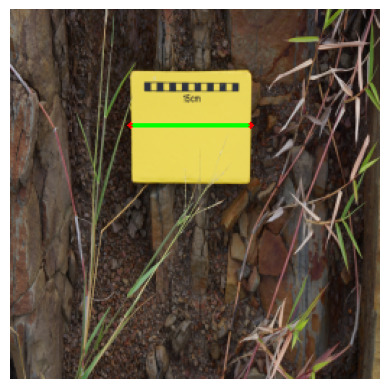

In [79]:
pt1, pt2 = measure_notebook_width(sample_img, sample_mask)
x1, y = pt1
x2, y = pt2
if pt1 is not None:
    img_copy = sample_img.copy()
    cv2.circle(img_copy, (x1, y), 2, (0, 0, 255), -1)
    cv2.circle(img_copy, (x2, y), 2, (0, 0, 255), -1)
    cv2.line(img_copy, (x1+2, y), (x2-2, y), (0, 255, 0), 2)
    plt.imshow(imshow(img_copy))
    plt.axis('off')
    plt.show()

In [ ]:
def get_scale(img, mask):
    '''
    Given a grayscale image and a mask, returns the scale object in the image.
    '''
    # get the foreground (0 corresponds to scale)
    _, scale_candidates = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY_INV)
    # find the largest contour
    cnts = cv2.findContours(scale_candidates, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    # sort the contours from left-to-righ
    (cnts, _) = contours.sort_contours(cnts)
    # get the largest contour using its area
    cont_max = max(cnts, key = cv2.contourArea)
    # find the bounding box of the contour
    x, y, w, h = cv2.boundingRect(cont_max)
    scale = img[y:y+h, x:x+w].copy()
    return scale

In [ ]:
scale = get_scale(img, mask)
imshow(scale)

In [ ]:
def get_contours(th, num_closing_iterations, element):
    '''
    horizontal closing and erosion followed by canny edge detection
    followed by contour finding
    '''
    # close the gaps between each black box
    morph = cv2.morphologyEx(th, cv2.MORPH_CLOSE, element, iterations=num_closing_iterations)
    # erode horizontally to get original width of strip
    morph = cv2.erode(morph, element)
    # get edges
    edges = cv2.Canny(morph, 100, 200)
    # get external contours
    cnts = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    return cnts

In [ ]:
def get_pixel_length_ratio(gray_img, mask, num_closing_iterations=2, actual_width=15, draw=False):
    """
    Calculates the pixel length ratio of a rectangular, yellowish scale object in a grayscale image.

    Parameters
    ----------
    gray_img : numpy.ndarray
        A grayscale image as a numpy array of shape (H, W).
    mask : numpy.ndarray
        A mask indicating the location of the scale object in the grayscale image, as a numpy array of shape (H, W).
    num_closing_iterations : int, optional
        Number of iterations to perform during closing of boxes in the strip.
    actual_width : int, optional
        The actual width of the scale object in centimeters. Default value is 15.
    actual_width : bool, optional
        Whether to draw the contour on the image for debugging purposes

    Returns
    -------
    float
        The ratio of the width of the scale object in pixels to its actual width in centimeters.

    Notes
    -----
    This function assumes that the grayscale image and mask have the same dimensions.
    The input values are expected to be in the correct range (0-2 for mask).
    """
    '''extract the scale from the mask'''
    # crop the mask to get roi for scale
    scale = get_scale(gray_img, mask)
    '''extract the boxes from the roi'''
    # blur to remove noise
    # blur = cv2.GaussianBlur(scale,(5,5),0)
    # blurring degrades thresholding so it is removed
    # threshold to get the black bloxes
    _, th = cv2.threshold(scale, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    # horizontal structuring element
    h_element = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 1))
    cnts = get_contours(th, num_closing_iterations, element=h_element)
    i = 0
    while len(cnts) > 10:
        i += 1
        cnts = get_contours(th, num_closing_iterations + i, element=h_element)
        # function failed
        if i > 5:
            return -1
    # sort the contours from left-to-right
    (cnts, _) = contours.sort_contours(cnts)
    for c in cnts:
        x, y, w, h = cv2.boundingRect(c)
        width_perc = round(w / scale.shape[1] * 100)
        area = cv2.contourArea(c)
        area_perc = area / (scale.shape[0] * scale.shape[1]) * 100
        area_perc = round(area_perc, 2)
        aspect_ratio = round(float(w) / h, 2)
        rect_area = w*h
        extent = round(float(area) / rect_area, 2)
        print('width_perc', width_perc)
        print('area_perc', area_perc)
        print('aspect_ratio', aspect_ratio)
        print()
        if width_perc < 65 or width_perc >= 99 or area_perc == 0 or aspect_ratio < 5.5:
            continue
        if draw:
            orig = scale.copy()
            box = cv2.minAreaRect(c)
            box = cv2.boxPoints(box)
            box = np.array(box, dtype="int")
            box = perspective.order_points(box).astype('int')
            cv2.drawContours(orig, [box], 0, (0, 255, 0), 1)
            plt.imshow(imshow(orig))
            plt.axis('off')
            plt.show()
        return round(w / actual_width, 1)
    return -2

In [ ]:
sample_img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ratio = get_pixel_length_ratio(sample_img_gray, mask, num_closing_iterations=2, actual_width=15, draw=True)
print(ratio)

### Debug

In [ ]:
imshow(sample_mask)

In [ ]:
def get_scale(img, mask):
    '''
    Given a grayscale image and a mask, returns the scale object in the image.
    '''
    # get the foreground (0 corresponds to scale)
    _, scale_candidates = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY_INV)
    # find the largest contour
    cnts = cv2.findContours(scale_candidates, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    # sort the contours from left-to-righ
    (cnts, _) = contours.sort_contours(cnts)
    # get the largest contour using its area
    cont_max = max(cnts, key = cv2.contourArea)
    # find the bounding box of the contour
    x, y, w, h = cv2.boundingRect(cont_max)
    scale = img[y:y+h, x:x+w].copy()
    mask_cropped = mask[y:y+h, x:x+w].copy()
    return scale, mask_cropped

In [ ]:
img = sample_img.copy()
gray_img = sample_img_gray.copy()
mask = sample_mask.copy()

scale, mask_cropped = get_scale(gray_img, mask)
imshow(scale)

In [ ]:
imshow(mask_cropped)

In [ ]:
# blur = cv2.GaussianBlur(scale,(5,5),0)
_, th = cv2.threshold(scale, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

imshow(th)

In [ ]:
h_element = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 1))

morph = cv2.morphologyEx(th, cv2.MORPH_CLOSE, h_element, iterations=2)
morph = cv2.erode(morph, h_element)

imshow(morph)

In [ ]:
edges = cv2.Canny(morph, 100, 200)
imshow(edges)

In [ ]:
cnts = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
# sort the contours from left-to-right and initialize the
# 'pixels per metric' calibration variable
(cnts, _) = contours.sort_contours(cnts)
len(cnts)

In [ ]:
for c in cnts:
    x,y,w,h = cv2.boundingRect(c)
    width_perc = round(w / scale.shape[1] * 100)
    area = cv2.contourArea(c)
    area_perc = area / (scale.shape[0] * scale.shape[1]) * 100
    area_perc = round(area_perc, 2)
    # Aspect ratio is the ratio of width to height of bounding rect of the object.
    aspect_ratio = round(float(w) / h, 2)
    rect_area = w*h
    # Extent is the ratio of contour area to bounding rectangle area.
    extent = round(float(area) / rect_area, 2)
    print(width_perc)
    if width_perc < 65 or width_perc >= 99 or area_perc == 0 or aspect_ratio < 2:
        continue
    print('area% extent ratio width width_perc')
    print(f'{area_perc}, {extent}, {aspect_ratio}, {w}, {width_perc}')
    # print('area_perc', area_perc)
    # print('extent', extent)
    # print('ratio', aspect_ratio)
    # print('width', w)
    print()

    # if extent < 0.4:
    #     continue
    # compute the rotated bounding box of the contour
    orig = scale.copy()
    box = cv2.minAreaRect(c)
    box = cv2.boxPoints(box)
    box = np.array(box, dtype="int")
    # order the points in the contour such that they appear
    # in top-left, top-right, bottom-right, and bottom-left
    # order, then draw the outline of the rotated bounding
    # box
    box = perspective.order_points(box).astype('int')
    cv2.drawContours(orig, [box], 0, (0, 255, 0), 1)
    # print(box)
    # loop over the original points and draw them
    # for (x, y) in box:
    #     cv2.circle(orig, (int(x), int(y)), 5, (0, 0, 255), -1)
    imshow(orig)
    print()

In [ ]:
# x_coords = []
# print('medians:', y1_med, y2_med)
# for c in cnts:
#     box = cv2.minAreaRect(c)
#     box = cv2.boxPoints(box)
#     box = np.array(box, dtype="int")
#     box = perspective.order_points(box)

#     y1, y2 = box[0, 1], box[2, 1]
#     if abs(y1 - y1_med) <= 2 and abs(y2 - y2_med) <= 2:
#         x_coords.append(box[0, 0])
#         x_coords.append(box[1, 0])
# width = max(x_coords) - min(x_coords)
# print(width)

In [ ]:
# coords = np.argwhere(morph == 255)
# y1 = coords[:, 0].min()
# y2 = coords[:, 0].max()
# x1 = coords[:, 0].min()
# x2 = coords[:, 1].max()
# width = x2 - x1
# print(width / 15)

## Actual Width Calculation

### Functions

#### Helpers

In [ ]:
def group_width(group):
    '''Get the width of a flat line'''
    return group[:, 0].max() - group[:, 0].min()

def group_points_by_y(points, y_range: float = 5):
    """
    Groups a list of 2D points based on their y-coordinates. Points whose y-coordinates are within a range of y_range are
    considered part of the same group.

    Args:
        points (list of list of int or float): A list of 2D points, where each point is represented as a list
            of two coordinates, [x, y].
        y_range (int): An int used to control the range of y coordinates in a group

    Returns:
        list of list of int or float: A list of point groups, where each group is represented as a list of
            points. Points within a group have y-coordinates that are within a range of y_range.

    Raises:
        TypeError: If the input points are not a list of list of int or float.

    Example:
        >>> points = [[0, 0], [1, 2], [2, 2], [3, 3], [4, 5], [5, 5]]
        >>> group_points_by_y(points, y_range=2)
        [[[0, 0], [1, 2], [2, 2]], [[3, 3], [4, 5], [5, 5]]]
    """
    # sort the points by y-coordinate
    points = np.squeeze(points)
    points = points[np.argsort(points[:, 1])]
    groups = []
    group = []
    for i in range(len(points)):
        if len(group) == 0:
            group.append(points[i].tolist())
        else:
            # check if the y-coordinate of the current point is within a range of y_range
            y1 = group[0][1]
            y2 = points[i][1]
            if abs(y2 - y1) <= y_range:
                group.append(points[i].tolist())
            else:
                groups.append(group)
                group = [points[i].tolist()]
    # don't create groups with 1 point only (the last point)
    if len(group) > 1:
        groups.append(group)
    return groups

def visualize_groups(image: np.ndarray, groups: list, straight: bool = False):
    # Copy the image to prevent editing the original image
    img_copy = image.copy()
    # Iterate over each group in the groups list
    colors = [(0, 0, 255), (0, 255, 0), (255, 0, 0)]
    i = 0
    for group in groups:
        if len(group) > 1:
            # Get the topmost and bottommost points of the group
            top_point = min(group, key=lambda x: x[1])
            bottom_point = max(group, key=lambda x: x[1])

            # Get the starting and ending coordinates of the arrow
            start_point = (int(top_point[0]), int(top_point[1]))
            if straight:
                end_point = (int(top_point[0]), int(bottom_point[1]))
            else:
                end_point = (int(bottom_point[0]), int(bottom_point[1]))
            # Draw the arrow on the image
            cv2.arrowedLine(img_copy, start_point, end_point, colors[i % 3], 2)
            i += 1
    return imshow(img_copy)


In [ ]:
def lies_inside_contour(cont, x1, x2, y):
    for x in range(x1 + 1, x2):
        p = np.array([x, y], dtype="uint8")
        result = cv2.pointPolygonTest(cont, p, False)
        if result == -1:
            return False
    return True


def get_width_and_residuals(group, cont):
    """
    group is sorted by x-coordinate
    this function should be called again on g2 until len(g2) <= 1
    """
    # Get the mean y-coordinate
    y_mean = np.mean(group[:, 1]).astype("uint8")
    x1, y1 = group[0]
    x_max = x1
    y2 = y1
    remaining_group = None
    for i in range(1, len(group)):
        x2, y2 = group[i]
        y_mean = (y1 + y2) // 2
        # mask errors at extremes
        if y_mean > 250:
            y_mean = 250
        if y_mean < 10:
            y_mean = 5
        if lies_inside_contour(cont, x1, x2, y_mean):
            if x2 > x_max:
                x_max = x2
        else:
            remaining_group = group[i:]
            break
    return (x1, x_max, (y1 + y2) // 2), remaining_group

In [ ]:
def keep_spaced_elements(unsorted_list, threshold):
    """
    Takes the unsorted list corresponding to the width of each flat line
    Returns a new list such that for every element i, j in the new list,
        the difference abs(i - j) >= threshold
    Keeps the larger element
    The indices of the elements to keep in the unsorted list are returned
    """
    n = len(unsorted_list)
    if n == 0:
        return []
    sorted_list = sorted(range(n), key=lambda i: unsorted_list[i])
    indices = [sorted_list[0]]
    for i in range(1, n):
        diff = unsorted_list[sorted_list[i]] - unsorted_list[indices[-1]]
        if abs(diff) >= threshold:
            indices.append(sorted_list[i])
        else:
            if diff > 0:
                del indices[-1]
                indices.append(sorted_list[i])
    return indices


def keep_varying_lines(flat_lines, line_sim_thresh):
    """
    Take the flat_lines and line similarity threshold as input
    Return all the lines whose difference is >= line_sim_thresh
    """
    if line_sim_thresh == 0:
        return flat_lines
    widths = [group_width(g) for g in flat_lines]
    indices_keep = keep_spaced_elements(widths, threshold=line_sim_thresh)
    flat_lines_filtered = [flat_lines[i] for i in indices_keep]
    widths = sorted([group_width(g) for g in flat_lines_filtered])
    return flat_lines_filtered


def keep_varying_lines_based_on_similarity(lines, y_range, threshold):
    if not lines: 
        return []
    lines.sort(key=lambda line: line[0][1])  # Sort by y value
    new_lines = [lines[0]]
    for i in range(1, len(lines)):
        current_line, previous_line = lines[i], new_lines[-1]
        if abs(current_line[0][1] - previous_line[0][1]) <= y_range:
            width_prev = group_width(previous_line)
            width_curr = group_width(current_line)
            if abs(width_prev - width_curr) < threshold:  # If widths are too similar
                # If the previous line was more similar to its neighbor than the current line, remove the previous line
                if i != len(lines) - 1:
                    next_line = lines[i+1]
                    width_next = group_width(next_line)
                    if abs(width_next - width_curr) > abs(width_next - width_prev):
                        new_lines.pop()
                        new_lines.append(current_line)
                    else:
                        continue
                else:
                    new_lines.pop()
                    new_lines.append(current_line)
            else:
                new_lines.append(current_line)
        else:
            new_lines.append(current_line)
    return new_lines

#### Main Functions

In [ ]:
def bresenham(x0, y0, x1, y1):
    """Yield integer coordinates on the line from (x0, y0) to (x1, y1).

    Input coordinates should be integers.

    The result will contain both the start and the end point.
    """
    dx = x1 - x0
    dy = y1 - y0

    xsign = 1 if dx > 0 else -1
    ysign = 1 if dy > 0 else -1

    dx = abs(dx)
    dy = abs(dy)

    if dx > dy:
        xx, xy, yx, yy = xsign, 0, 0, ysign
    else:
        dx, dy = dy, dx
        xx, xy, yx, yy = 0, ysign, xsign, 0

    D = 2*dy - dx
    y = 0

    for x in range(dx + 1):
        yield x0 + x*xx + y*yx, y0 + x*xy + y*yy
        if D >= 0:
            y += 1
            D -= 2*dx
        D += 2*dy

In [ ]:
def trace_contour(contour):
    contour_new = []
    for i in range(len(contour) - 1):
        p1 = contour[i][0]
        p2 = contour[i + 1][0]
        interpolated = list(bresenham(p1[0], p1[1], p2[0], p2[1]))
        contour_new.extend(interpolated)
    contour_new.append(contour[-1][0])
    contour = np.array(contour_new, dtype='int32')
    contour = np.expand_dims(contour, axis=1)
    return contour

In [ ]:
def find_flat_lines(
    contour: np.ndarray,
    img: np.ndarray,
    w_min: float = 0,
    w_max: float = float("inf"),
    line_sim_thresh: float = 5.0,
    ratio: float = 1,
    group_y_range: float = 2,
):
    # perform contour tracing
    contour = trace_contour(contour)
    # group points by their y-coordinates
    groups = group_points_by_y(contour, y_range=group_y_range)
    # initialize the list of flat lines
    flat_lines = []
    # iterate over each group of points
    for i in range(len(groups)):
        # convert to numpy array
        group = np.array(groups[i])
        # sort group by x-coordinate
        group = group[np.argsort(group[:, 0])]
        remaining_group = group.copy()
        while remaining_group is not None and len(remaining_group) >= 2:
            (x_min, x_max, y_mean), remaining_group = get_width_and_residuals(
                remaining_group, contour
            )
            # compute the width of the group
            width = x_max - x_min
            # add the group if its width is >= the threshold
            if w_min <= width <= w_max:
                line = np.array([[x_min, y_mean], [x_max, y_mean]])
                flat_lines.append(line)
    # remove lines with similar widths
    # flat_lines = keep_varying_lines(flat_lines, line_sim_thresh)
    flat_lines = keep_varying_lines_based_on_similarity(flat_lines, group_y_range, line_sim_thresh)
    # the number of flat lines is the number of groups
    num_flat_lines = len(flat_lines)
    # add arrows to show the flat lines
    avg_width = 0
    for i in range(num_flat_lines):
        line = np.array(flat_lines[i])
        x_min = np.min(line[:, 0]).astype("uint8")
        x_max = np.max(line[:, 0]).astype("uint8")
        y = np.mean(line[:, 1]).astype("uint8")
        width = (x_max - x_min) / ratio
        width = round(width, 1)
        avg_width += width
        text = str(width)
        yloc = int(y) + 10
        if yloc >= 240:
            yloc = int(y) - 5
        cv2.arrowedLine(img, (x_min, y), (x_max, y), (0, 255, 0), 2)
        if x_min >= 230:
            x_min -= 5
        cv2.putText(
            img, text, (x_min, yloc), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1
        )
    avg_width /= num_flat_lines
    avg_width = round(avg_width, 1)
    return avg_width, img

In [ ]:
def draw_widths(
    img: np.ndarray,
    mask: np.ndarray,
    ratio: float = 1.0,
    w_min: float = 0,
    w_max: float = float("inf"),
    line_sim_thresh: float = 0.0,
    group_y_range: float = 1.0,
):
    # threshold the mudstone
    thresh = np.where(mask == name2id["mudstone"], 255, 0).astype(np.uint8)
    kernel = np.ones((32, 3), np.uint8)
    morph = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
    """contour analysis"""
    cnts = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    # sort the contours from left-to-right
    (cnts, _) = contours.sort_contours(cnts)
    # adjust thresholds based on ratio
    w_min *= ratio
    w_max *= ratio
    line_sim_thresh *= ratio
    group_y_range *= ratio
    anno_imgs = []
    cnts_filtered = []
    avg_widths = []
    orig = img.copy()
    for c in cnts:
        # copy the original image to prevent editing it
        h, w = orig.shape[:2]
        # minimum contour area should be >= 2% of image
        area = cv2.contourArea(c)
        perc = area / (h * w) * 100
        if perc < 2:
            continue
        cnts_filtered.append(c)
        cv2.drawContours(orig, [c], 0, (255, 0, 0), 1)
        # find the widths
        avg_width, orig_lines_drawn = find_flat_lines(
            c,
            orig,
            w_min=w_min,
            w_max=w_max,
            line_sim_thresh=line_sim_thresh,
            ratio=ratio,
            group_y_range=group_y_range,
        )
        anno_imgs.append(orig_lines_drawn)
        avg_widths.append(avg_width)
    return anno_imgs, avg_widths, cnts_filtered

In [ ]:
def display_images(images, titles=None):
    # Number of images
    n_images = len(images)

    # Calculate the layout for the grid
    n_cols = min(4, n_images)  # Up to 4 columns
    n_rows = math.ceil(n_images / n_cols)
    # Create the subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows*6))

    # Add padding between images
    fig.subplots_adjust(wspace=0.02, hspace=0.02)

    # Make axes a 2D array even if n_rows or n_cols is 1
    axes = np.array([axes]).reshape((n_rows, n_cols))
    # Display the images on the grid
    for i, img in enumerate(images):
        row, col = divmod(i, n_cols)
        axes[row, col].imshow(imshow(img))
        axes[row, col].axis('off')
        if titles:
            axes[row, col].set_title(f'Avg width: {titles[i]}cm')

    # Remove unused subplots
    for j in range(i+1, n_rows*n_cols):
        row, col = divmod(j, n_cols)
        fig.delaxes(axes[row, col])
    plt.subplots_adjust(hspace=0.02, wspace=0.02)
    # plt.savefig('process_diagram/4_2.png', dpi=600)
    plt.show()

### Test

In [ ]:
results = []
for ind in indices[13:]:
    sample_img, sample_mask, factor = get_img_and_mask(ind)
    img = sample_img.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    mask = sample_mask.copy()
    # ratio = 1
    # print(ratio)
    annos, widths, cnts = draw_widths(
        img,
        mask,
        ratio=1,
        w_min=10,
        w_max=1000,
        line_sim_thresh=3,
        group_y_range=40,
    )
    results.append(imshow(annos[-1]))


In [ ]:
i = 2
print(image_files[indices[i+13]])
results[i]

In [ ]:
# Create a figure to hold the subplots
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
# Flatten the 2D array of axes into a 1D array for easy iterating
axs = axs.ravel()
# For each image and corresponding subplot
for i, img in enumerate(results):
    axs[i].imshow(img)  # Display the image in the subplot
    axs[i].axis('off')  # Hide axis
plt.tight_layout()
plt.subplots_adjust(wspace=0.02, hspace=0.02)
plt.savefig('process_diagram/results_sd.png', dpi=600)
plt.show()

In [ ]:
for ind in indices:
    sample_img, sample_mask, factor = get_img_and_mask(ind)
    img = sample_img.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    mask = sample_mask.copy()
    # ratio = 1
    # print(ratio)
    annos, widths, cnts = draw_widths(
        img,
        mask,
        ratio=ratio,
        w_min=10,
        w_max=1000,
        line_sim_thresh=2.5,
        group_y_range=24,
    )
    display_images(annos, widths)


In [ ]:
groups = group_points_by_y(cnt, y_range=8)
visualize_groups(img, groups, straight=True)

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(5,5))
cnt = cnts[0]
cnt_exp = trace_contour(cnt)
groups = group_points_by_y(cnt_exp, y_range=8)
im = sample_img.copy()
cv2.drawContours(im, [cnt], 0, (255, 0, 0), 1)
axes[0, 0].imshow(visualize_groups(im, groups, straight=True))
axes[0, 0].axis('off')

cnt = cnts[1]
cnt_exp = trace_contour(cnt)
groups = group_points_by_y(cnt_exp, y_range=8)
im = sample_img.copy()
cv2.drawContours(im, [cnt], 0, (255, 0, 0), 1)
axes[0, 1].imshow(visualize_groups(im, groups, straight=True))
axes[0, 1].axis('off')

cnt = cnts[2]
cnt_exp = trace_contour(cnt)
groups = group_points_by_y(cnt_exp, y_range=8)
im = sample_img.copy()
cv2.drawContours(im, [cnt], 0, (255, 0, 0), 1)
axes[1, 0].imshow(visualize_groups(im, groups, straight=True))
axes[1, 0].axis('off')

cnt = cnts[3]
cnt_exp = trace_contour(cnt)
groups = group_points_by_y(cnt_exp, y_range=8)
im = sample_img.copy()
cv2.drawContours(im, [cnt], 0, (255, 0, 0), 1)
axes[1, 1].imshow(visualize_groups(im, groups, straight=True))
axes[1, 1].axis('off')
plt.tight_layout()
plt.subplots_adjust(wspace=0.02, hspace=0.02)
plt.savefig('process_diagram/3.png', dpi=600)

In [ ]:
save = annos[2]
save = cv2.rotate(save, cv2.ROTATE_90_CLOCKWISE)
imshow(save)

#### Debug

In [ ]:
thresh = np.where(mask == 2, 255, 0).astype(np.uint8)
imshow(thresh)

In [ ]:
morph = thresh.copy()

In [ ]:
big_element = cv2.getStructuringElement(cv2.MORPH_RECT,(7,7))
small_element = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))

# remove small rectangles
morph = cv2.morphologyEx(morph, cv2.MORPH_OPEN, big_element, iterations=1)
# restore connections
morph = cv2.morphologyEx(morph, cv2.MORPH_CLOSE, big_element, iterations=1)
# remove extraneous connections
morph = cv2.morphologyEx(morph, cv2.MORPH_OPEN, small_element, iterations=1)
imshow(morph)

##### Contours

In [ ]:
# find the largest contour
cnts = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
# sort the contours from left-to-right
(cnts, _) = contours.sort_contours(cnts)

for c in cnts:
    orig = img.copy()
    h,w = orig.shape[:2]
    area = cv2.contourArea(c)
    perc = area / (h * w) * 100
    if perc < 2:
        continue
    cv2.drawContours(orig, [c], 0, (0,255,0), 2)
    plt.imshow(imshow(orig))
    plt.axis('off')
    print()

In [ ]:
w_min = 4 * ratio
w_max = 100 * ratio
line_sim_thresh = 6 * ratio

for c in cnts[0:1]:
    orig = img.copy()
    h, w = orig.shape[:2]
    area = cv2.contourArea(c)
    perc = area / (h * w) * 100
    if perc < 2:
        continue
    cv2.drawContours(orig, [c], 0, (255,0,0), 1)
    flat_lines, num_flat_lines, orig = find_flat_lines(c, orig,
                                                       w_min=w_min,
                                                       w_max=w_max,
                                                       line_sim_thresh=line_sim_thresh,
                                                       ratio=ratio,
                                                       group_y_range=2)
    # print(num_flat_lines)
    plt.imshow(imshow(orig))
    plt.axis('off')
    print()


##### Connected Components

In [ ]:
def draw_widths_old(mask, img, ratio, erosion_it=2):
    thresh = np.where(sample_mask == 2, 255, 0).astype(np.uint8)

    morph = cv2.erode(thresh, None, iterations=erosion_it)
    morph = cv2.dilate(morph, None, iterations=1)

    output = cv2.connectedComponentsWithStats(morph, 8, cv2.CV_32S)
    (numLabels, labels, stats, centroids) = output

    # loop over the number of unique connected component labels
    for i in range(numLabels):
        # if this is the first component then we examine the
        # *background* (typically we would just ignore this
        # component in our loop)
        if i == 0:
            text = "skipping component {}/{} (background)".format(
                i + 1, numLabels)
            continue
        # otherwise, we are examining an actual connected component
        else:
            text = "examining component {}/{}".format( i + 1, numLabels)
        # print a status message update for the current connected
        # component
        print("[INFO] {}".format(text))
        # extract the connected component statistics and centroid for
        # the current label
        x = stats[i, cv2.CC_STAT_LEFT]
        y = stats[i, cv2.CC_STAT_TOP]
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]
        print('width:', w)
        area = stats[i, cv2.CC_STAT_AREA]
        (cX, cY) = centroids[i]
        output = sample_img.copy()
        cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 3)
        actual_length = (w / ratio).round(1)
        cv2.arrowedLine(output, (x, int(cY)), (x + w, int(cY)), (0, 0, 255), 1)
        text = f'{actual_length}cm'
        cv2.putText(output, text, (x, int(cY)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 1)
        # cv2.circle(output, (int(cX), int(cY)), 4, (0, 0, 255), -1)
        componentMask = (labels == i).astype("uint8") * 255
        plt.imshow(imshow(output))
        plt.imshow(imshow(componentMask))
        plt.axis('off')
        print()

In [ ]:
output = cv2.connectedComponentsWithStats(morph, 8, cv2.CV_32S)
(numLabels, labels, stats, centroids) = output

# loop over the number of unique connected component labels
for i in range(numLabels):
    # if this is the first component then we examine the
    # *background* (typically we would just ignore this
    # component in our loop)
    if i == 0:
        text = "skipping component {}/{} (background)".format(
            i + 1, numLabels)
        continue
    # otherwise, we are examining an actual connected component
    else:
        text = "examining component {}/{}".format( i + 1, numLabels)
    # print a status message update for the current connected
    # component
    print("[INFO] {}".format(text))
    # extract the connected component statistics and centroid for
    # the current label
    x = stats[i, cv2.CC_STAT_LEFT]
    y = stats[i, cv2.CC_STAT_TOP]
    w = stats[i, cv2.CC_STAT_WIDTH]
    h = stats[i, cv2.CC_STAT_HEIGHT]
    print('width:', w)
    area = stats[i, cv2.CC_STAT_AREA]
    (cX, cY) = centroids[i]
    output = sample_img.copy()
    cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 3)
    actual_length = (w / ratio).round(1)
    cv2.arrowedLine(output, (x, int(cY)), (x + w, int(cY)), (0, 0, 255), 1)
    text = f'{actual_length}cm'
    cv2.putText(output, text, (x, int(cY)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 1)
    # cv2.circle(output, (int(cX), int(cY)), 4, (0, 0, 255), -1)
    componentMask = (labels == i).astype("uint8") * 255
    plt.imshow(imshow(output))
    plt.imshow(imshow(componentMask))
    plt.axis('off')
    print()
    print()